# Multi-layer Perceptron(MLP)

## Install Library & requirements

In [ ]:
!pwd

In [1]:
import os
import sys
from datetime import datetime

drive_project_root = "/home/jmj3047/mj_MLP_prac"
sys.path.append(drive_project_root)


In [ ]:
!pip install -r "/home/jmj3047/mj_MLP_prac/requirements.txt"

In [ ]:
!pip install nvidia-pyindex

In [ ]:
!pip install --pre torch torchvision torchaudio torch-nightly -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html

In [ ]:
!pip install torchvision

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [3]:
#!pwd
data_root = os.path.join(os.getcwd(), 'data')

#preprocessing & 데이터 셋 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) #mean, std
    ]
)

fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)


## DataLoader 정의

In [4]:
from torch.utils.data import random_split
from data_utils import dataset_split

In [5]:
datasets= dataset_split(fashion_mnist_dataset, split=[0.9,0.1])

train_dataset = datasets['train']
val_dataset = datasets['val']

train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = train_batch_size, shuffle=True, num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = val_batch_size, shuffle=True, num_workers=1
)

In [6]:
for sample_batch in train_dataloader:
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

#torch.Size([100, 1, 28, 28]) batchsize, channel, width, height

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 모델(Multi-Layer Perceptron) (MLP) 정의

In [7]:
import torch. nn.functional as F

In [8]:
#Define Model

class MLP(nn.Module):
    def __init__(self, in_dim=int, h1_dim = int, h2_dim = int, out_dim = int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu #activation 함수 정의

        pass

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = F.sigmoid(out) #binary classification은 softmax로 사용
        return out

## 모델 선언 및 손실함수, 최적화(Optimizer) 정의, Tensorboard Logger 정의

In [12]:
#define model
model = MLP(28*28, 128, 64, 10)

#define loss
loss_function = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
max_epoch = 15

#define tensorboard logger
writer = SummaryWriter()
log_interval =100

In [18]:
%load_ext tensorboard
%tensorboard --logdir runs/ #여기다가 log를 쌓을거고 거기 있는걸 plot해달라는 의미

train_step = 0
for epoch in range(1, max_epoch+1):
    #validation step
    with torch.no_grad(): # optimizer가 업데이트 하면 안됨
        val_loss = 0.0
        val_corrects = 0

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc = 'validation')
        ):
            #forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            #loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0] #이게 batch size. batch size만큼 평균을 내겠다는 뜻
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
        
        #valid step logging
        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_acc = val_corrects/len(val_dataloader)
        print(
            f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}" 
        )
        writer.add_scalar("Loss/val", val_epoch_loss, train_step)
        writer.add_scalar("Acc/val", val_epoch_acc, train_step)
        writer.add_images("Images/val", val_images, train_step)
        
        
        #train step
        current_loss = 0
        current_corrects = 0
                





    #train step
    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc = 'train')
    ):
        current_loss = 0.0
        current_corrects = 0

        #get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # print(outputs)
        # print(preds)
        
        #get loss
        loss = loss_function(outputs, labels)


        ###### 여기까지가 forward ###

        #Backpropagation

        #optimitizer 초기화(zero화)
        optimizer.zero_grad()

        #perform backward pass
        loss.backward()

        #perfrom optimization
        optimizer.step()

        current_loss +=loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects/log_interval
            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}" 
            )
            writer.add_scalar("Loss/train", train_step)
            writer.add_scalar("Acc/train", train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_graph(model, images)
            current_loss = 0
            current_corrects = 0

        train_step += 1



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 31906), started 0:38:55 ago. (Use '!kill 31906' to kill it.)

train:   0%|          | 0/540 [00:00<?, ?it/s]

1 epoch, 0 step: val_loss: 0.15442787110805511, val_acc: 0.878831148147583
0: train_loss: 0.015415202379226684, train_acc: 0.8799999952316284


train:  19%|█▊        | 101/540 [00:02<00:13, 32.21it/s]

100: train_loss: 0.014970043897628784, train_acc: 0.9399999976158142


train:  38%|███▊      | 205/540 [00:05<00:08, 37.50it/s]

200: train_loss: 0.015535529851913452, train_acc: 0.8799999952316284


train:  56%|█████▋    | 305/540 [00:08<00:06, 35.53it/s]

300: train_loss: 0.015212417840957641, train_acc: 0.9100000262260437


train:  74%|███████▍  | 401/540 [00:11<00:05, 26.56it/s]

400: train_loss: 0.015356417894363403, train_acc: 0.8999999761581421


train:  93%|█████████▎| 504/540 [00:13<00:00, 37.61it/s]

500: train_loss: 0.015132818222045898, train_acc: 0.9100000262260437


train:   0%|          | 0/540 [00:00<?, ?it/s]

2 epoch, 540 step: val_loss: 0.15449735522270203, val_acc: 0.8729978203773499


train:  12%|█▏        | 64/540 [00:01<00:14, 33.62it/s]

600: train_loss: 0.015075355768203735, train_acc: 0.8999999761581421


train:  31%|███       | 165/540 [00:04<00:10, 35.53it/s]

700: train_loss: 0.015547572374343873, train_acc: 0.8600000143051147


train:  49%|████▊     | 263/540 [00:07<00:16, 17.21it/s]

800: train_loss: 0.01536180853843689, train_acc: 0.8899999856948853


train:  67%|██████▋   | 363/540 [00:10<00:05, 32.94it/s]

900: train_loss: 0.015107264518737793, train_acc: 0.9100000262260437


train:  85%|████████▌ | 461/540 [00:12<00:02, 32.45it/s]

1000: train_loss: 0.015192936658859253, train_acc: 0.8799999952316284


train:   0%|          | 0/540 [00:00<?, ?it/s]

3 epoch, 1080 step: val_loss: 0.15428252518177032, val_acc: 0.8714978098869324


train:   4%|▍         | 24/540 [00:00<00:16, 30.39it/s]

1100: train_loss: 0.015099927186965942, train_acc: 0.9399999976158142


train:  24%|██▎       | 127/540 [00:03<00:09, 41.64it/s]

1200: train_loss: 0.015138565301895142, train_acc: 0.9100000262260437


train:  41%|████      | 221/540 [00:05<00:09, 33.76it/s]

1300: train_loss: 0.015163754224777221, train_acc: 0.8700000047683716


train:  61%|██████    | 327/540 [00:08<00:05, 41.20it/s]

1400: train_loss: 0.015165438652038574, train_acc: 0.8600000143051147


train:  78%|███████▊  | 422/540 [00:11<00:03, 34.84it/s]

1500: train_loss: 0.015266433954238892, train_acc: 0.8999999761581421


train:  97%|█████████▋| 524/540 [00:14<00:01, 15.50it/s]

1600: train_loss: 0.015220707654953003, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

4 epoch, 1620 step: val_loss: 0.1546698361635208, val_acc: 0.8698309063911438


train:  15%|█▌        | 81/540 [00:02<00:14, 32.60it/s]

1700: train_loss: 0.015032657384872437, train_acc: 0.8999999761581421


train:  33%|███▎      | 177/540 [00:04<00:08, 41.24it/s]

1800: train_loss: 0.015179382562637329, train_acc: 0.9200000166893005


train:  52%|█████▏    | 281/540 [00:07<00:08, 31.78it/s]

1900: train_loss: 0.01513153076171875, train_acc: 0.9200000166893005


train:  71%|███████▏  | 385/540 [00:10<00:04, 33.26it/s]

2000: train_loss: 0.015368449687957763, train_acc: 0.8799999952316284


train:  89%|████████▉ | 481/540 [00:13<00:02, 20.40it/s]

2100: train_loss: 0.01517575979232788, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

5 epoch, 2160 step: val_loss: 0.15441645681858063, val_acc: 0.8819978833198547


train:   8%|▊         | 43/540 [00:01<00:17, 28.75it/s]

2200: train_loss: 0.015059973001480103, train_acc: 0.8999999761581421


train:  26%|██▋       | 142/540 [00:04<00:16, 24.80it/s]

2300: train_loss: 0.015219378471374511, train_acc: 0.8500000238418579


train:  45%|████▌     | 244/540 [00:07<00:09, 32.73it/s]

2400: train_loss: 0.015035209655761718, train_acc: 0.9200000166893005


train:  63%|██████▎   | 341/540 [00:09<00:05, 36.56it/s]

2500: train_loss: 0.015428249835968017, train_acc: 0.8799999952316284


train:  83%|████████▎ | 446/540 [00:12<00:03, 31.02it/s]

2600: train_loss: 0.015150195360183716, train_acc: 0.9100000262260437


train:   0%|          | 0/540 [00:00<?, ?it/s]

6 epoch, 2700 step: val_loss: 0.1541125327348709, val_acc: 0.8749979734420776
2700: train_loss: 0.015159525871276856, train_acc: 0.9200000166893005


train:  19%|█▉        | 104/540 [00:02<00:13, 33.26it/s]

2800: train_loss: 0.015571682453155518, train_acc: 0.8100000023841858


train:  38%|███▊      | 203/540 [00:05<00:09, 35.82it/s]

2900: train_loss: 0.01517907977104187, train_acc: 0.9300000071525574


train:  56%|█████▌    | 303/540 [00:08<00:06, 34.44it/s]

3000: train_loss: 0.015288811922073365, train_acc: 0.8899999856948853


train:  74%|███████▍  | 402/540 [00:10<00:03, 36.34it/s]

3100: train_loss: 0.015045329332351684, train_acc: 0.9300000071525574


train:  94%|█████████▎| 505/540 [00:13<00:00, 36.02it/s]

3200: train_loss: 0.015056490898132324, train_acc: 0.9300000071525574


train:   0%|          | 0/540 [00:00<?, ?it/s]

7 epoch, 3240 step: val_loss: 0.1544002741575241, val_acc: 0.8774981498718262


train:  11%|█▏        | 62/540 [00:01<00:14, 33.85it/s]

3300: train_loss: 0.015252161026000976, train_acc: 0.8999999761581421


train:  30%|███       | 163/540 [00:04<00:11, 31.56it/s]

3400: train_loss: 0.014953904151916504, train_acc: 0.9399999976158142


train:  49%|████▊     | 263/540 [00:07<00:07, 36.71it/s]

3500: train_loss: 0.01526183009147644, train_acc: 0.8500000238418579


train:  67%|██████▋   | 362/540 [00:09<00:04, 36.75it/s]

3600: train_loss: 0.015194419622421265, train_acc: 0.9100000262260437


train:  86%|████████▌ | 462/540 [00:12<00:02, 32.70it/s]

3700: train_loss: 0.015518569946289062, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

8 epoch, 3780 step: val_loss: 0.1541142463684082, val_acc: 0.881831169128418


train:   4%|▍         | 21/540 [00:00<00:21, 23.60it/s]

3800: train_loss: 0.015154235363006592, train_acc: 0.9399999976158142


train:  23%|██▎       | 125/540 [00:04<00:11, 35.18it/s]

3900: train_loss: 0.015357372760772705, train_acc: 0.8399999737739563


train:  41%|████▏     | 224/540 [00:06<00:09, 34.92it/s]

4000: train_loss: 0.015182194709777832, train_acc: 0.8899999856948853


train:  60%|█████▉    | 322/540 [00:09<00:06, 33.24it/s]

4100: train_loss: 0.015056544542312622, train_acc: 0.8999999761581421


train:  78%|███████▊  | 423/540 [00:12<00:04, 25.09it/s]

4200: train_loss: 0.015412516593933105, train_acc: 0.9100000262260437


train:  96%|█████████▋| 521/540 [00:14<00:00, 34.49it/s]

4300: train_loss: 0.015051442384719848, train_acc: 0.8700000047683716


train:   0%|          | 0/540 [00:00<?, ?it/s]

9 epoch, 4320 step: val_loss: 0.15449875593185425, val_acc: 0.8754979372024536


train:  15%|█▌        | 82/540 [00:02<00:14, 31.45it/s]

4400: train_loss: 0.0149621844291687, train_acc: 0.9399999976158142


train:  34%|███▍      | 185/540 [00:05<00:10, 35.14it/s]

4500: train_loss: 0.015149924755096435, train_acc: 0.8600000143051147


train:  52%|█████▏    | 283/540 [00:07<00:07, 33.18it/s]

4600: train_loss: 0.015407344102859497, train_acc: 0.8700000047683716


train:  71%|███████   | 383/540 [00:10<00:04, 34.43it/s]

4700: train_loss: 0.015202400684356689, train_acc: 0.9300000071525574


train:  89%|████████▉ | 481/540 [00:13<00:03, 19.63it/s]

4800: train_loss: 0.01512494683265686, train_acc: 0.8500000238418579


train:   0%|          | 0/540 [00:00<?, ?it/s]

10 epoch, 4860 step: val_loss: 0.1538422703742981, val_acc: 0.8796648383140564


train:   8%|▊         | 44/540 [00:01<00:17, 29.07it/s]

4900: train_loss: 0.015289928913116455, train_acc: 0.8700000047683716


train:  26%|██▋       | 143/540 [00:04<00:12, 32.44it/s]

5000: train_loss: 0.015193562507629394, train_acc: 0.9100000262260437


train:  45%|████▍     | 242/540 [00:07<00:09, 30.87it/s]

5100: train_loss: 0.015541598796844483, train_acc: 0.8500000238418579


train:  64%|██████▎   | 343/540 [00:09<00:05, 34.62it/s]

5200: train_loss: 0.015056750774383544, train_acc: 0.8999999761581421


train:  82%|████████▏ | 444/540 [00:12<00:02, 36.99it/s]

5300: train_loss: 0.015019530057907104, train_acc: 0.9100000262260437


train:   0%|          | 0/540 [00:00<?, ?it/s]

11 epoch, 5400 step: val_loss: 0.1544853150844574, val_acc: 0.8774980902671814
5400: train_loss: 0.015227829217910766, train_acc: 0.8899999856948853


train:  19%|█▉        | 105/540 [00:02<00:12, 35.52it/s]

5500: train_loss: 0.01543472170829773, train_acc: 0.8999999761581421


train:  39%|███▊      | 208/540 [00:06<00:10, 31.43it/s]

5600: train_loss: 0.015334858894348144, train_acc: 0.8999999761581421


train:  56%|█████▋    | 304/540 [00:08<00:07, 33.52it/s]

5700: train_loss: 0.015057008266448974, train_acc: 0.9200000166893005


train:  75%|███████▍  | 403/540 [00:11<00:03, 34.66it/s]

5800: train_loss: 0.014958412647247314, train_acc: 0.9100000262260437


train:  94%|█████████▎| 506/540 [00:14<00:01, 32.33it/s]

5900: train_loss: 0.015343955755233764, train_acc: 0.8600000143051147


train:   0%|          | 0/540 [00:00<?, ?it/s]

12 epoch, 5940 step: val_loss: 0.15395957231521606, val_acc: 0.882664680480957


train:  12%|█▏        | 65/540 [00:01<00:14, 33.63it/s]

6000: train_loss: 0.015406248569488525, train_acc: 0.8899999856948853


train:  31%|███       | 165/540 [00:04<00:10, 35.96it/s]

6100: train_loss: 0.015377898216247559, train_acc: 0.8899999856948853


train:  49%|████▉     | 265/540 [00:07<00:07, 35.99it/s]

6200: train_loss: 0.015023962259292603, train_acc: 0.8999999761581421


train:  67%|██████▋   | 363/540 [00:09<00:04, 38.69it/s]

6300: train_loss: 0.01497289776802063, train_acc: 0.8999999761581421


train:  86%|████████▌ | 465/540 [00:12<00:02, 35.29it/s]

6400: train_loss: 0.015293759107589722, train_acc: 0.8999999761581421


train:   0%|          | 0/540 [00:00<?, ?it/s]

13 epoch, 6480 step: val_loss: 0.1540965586900711, val_acc: 0.8824981451034546


train:   4%|▍         | 22/540 [00:00<00:21, 24.65it/s]

6500: train_loss: 0.015004404783248902, train_acc: 0.8999999761581421


train:  23%|██▎       | 123/540 [00:03<00:12, 32.45it/s]

6600: train_loss: 0.015148245096206665, train_acc: 0.8899999856948853


train:  41%|████      | 222/540 [00:06<00:17, 18.22it/s]

6700: train_loss: 0.014884269237518311, train_acc: 0.9100000262260437


train:  60%|█████▉    | 323/540 [00:09<00:06, 33.65it/s]

6800: train_loss: 0.015446666479110718, train_acc: 0.8799999952316284


train:  78%|███████▊  | 423/540 [00:11<00:04, 28.12it/s]

6900: train_loss: 0.015086848735809327, train_acc: 0.9399999976158142


train:  96%|█████████▋| 521/540 [00:14<00:00, 34.83it/s]

7000: train_loss: 0.015109068155288697, train_acc: 0.8999999761581421


train:   0%|          | 0/540 [00:00<?, ?it/s]

14 epoch, 7020 step: val_loss: 0.15425923466682434, val_acc: 0.8836648464202881


train:  15%|█▌        | 82/540 [00:02<00:13, 34.03it/s]

7100: train_loss: 0.015533626079559326, train_acc: 0.8799999952316284


train:  34%|███▎      | 182/540 [00:04<00:12, 28.49it/s]

7200: train_loss: 0.015100162029266357, train_acc: 0.9200000166893005


train:  53%|█████▎    | 284/540 [00:07<00:07, 34.20it/s]

7300: train_loss: 0.01501742124557495, train_acc: 0.9399999976158142


train:  71%|███████   | 381/540 [00:10<00:05, 31.61it/s]

7400: train_loss: 0.014911319017410279, train_acc: 0.9300000071525574


train:  89%|████████▉ | 482/540 [00:12<00:01, 34.40it/s]

7500: train_loss: 0.015053364038467408, train_acc: 0.949999988079071


train:   0%|          | 0/540 [00:00<?, ?it/s]

15 epoch, 7560 step: val_loss: 0.15406091511249542, val_acc: 0.8808310031890869


train:   8%|▊         | 41/540 [00:01<00:23, 21.07it/s]

7600: train_loss: 0.015122618675231934, train_acc: 0.9200000166893005


train:  27%|██▋       | 144/540 [00:04<00:12, 31.66it/s]

7700: train_loss: 0.015045421123504639, train_acc: 0.8899999856948853


train:  46%|████▌     | 247/540 [00:07<00:07, 38.26it/s]

7800: train_loss: 0.015174275636672974, train_acc: 0.9100000262260437


train:  64%|██████▎   | 344/540 [00:09<00:05, 33.44it/s]

7900: train_loss: 0.015036412477493287, train_acc: 0.9200000166893005


train:  82%|████████▏ | 443/540 [00:12<00:02, 33.44it/s]

8000: train_loss: 0.014998730421066284, train_acc: 0.9100000262260437


train: 100%|██████████| 540/540 [00:15<00:00, 35.86it/s]


In [20]:
# save model
os.makedirs("./logs/models", exist_ok=True)
torch.save(model, "./logs/models/mlp.ckpt")

In [21]:
# load model
loaded_model = torch.load("./logs/models/mlp.ckpt")
loaded_model.eval()
print(loaded_model)

MLP(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [23]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis = axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [25]:
test_batch_size = 100
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []


for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_preds.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list==test_labels_list)*100}%")

testing:   0%|          | 0/100 [00:00<?, ?it/s]/home/jmj3047/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
testing: 100%|██████████| 100/100 [00:01<00:00, 70.70it/s]

acc: 100.0%


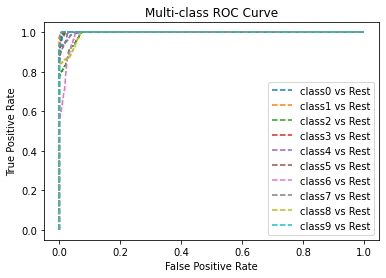

0.996390865749755


In [30]:
#ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr={}
tpr={}
thresh={}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label=i)

#print(fpr)

#plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle = '--', label=f"class{i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print(roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro'))